<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [CS4740 Labs] Week 6: Deep Generative Models

##Introduction

One of the big successes of Deep Learning that sparked significant interest in the last few years is Deep Generative Models. These are deep neural architectures whose main goal is *analysis-by-synthesis*. In other words, they represent an attempt to analyse a complex dataset by synthesizing new datapoints that preserve the statistical properties of the original data. In achieving this, the deep generative models are able to extract meaningful information about the statistical distribution that gave rise to the original dataset, thereby providing us with some sort of *high-level understanding*. 

These Deep Generative architectures have been used to generate realistic data from a variety of sources, including among others, celebrity face images and artistic paintings!

In this lab we will explore some of the properties of Deep Generative Models by running several experiments using simple versions of popular generative architectures. 

##A very simple VAE

Let's begin by exploring a very simple toy dimensionality reduction problem. To keep things easy to visualize, we will limit ourselves to two dimensions. The code below generates the well known spiral dataset. 

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np

def spiral(n_points, noise=1.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    dx = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    dy = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return np.hstack((dx,dy))

Let's see what this looks like:

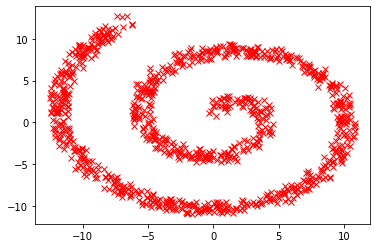

In [7]:
X = spiral(n_points=1000)
plt.plot(X[:,0],X[:,1],'rx')

What we immediately observe is that while the points are two-dimensional, the space they come from is only one-dimensional. Which means this dataset could be a good candidate for a Variational Auto-Encoder with a 1-dimensional encoding. We will be using the simple MLP class below for both encoder and decoder networks. The network layers are generated according to the input of the constructor. The `hidden` holds the sizes of all the hidden layers (if any). We also define the input and output sizes. 

In [1]:
class MLPNet(nn.Module):
    def __init__(self, input_size=2, hidden=[3], output_size=2):
        super(MLPNet, self).__init__()
        s0=input_size
        self.hidden_layers = nn.ModuleList()
        for h in hidden:
            self.hidden_layers.append(nn.Sequential(nn.Linear(s0,h),nn.LeakyReLU()))
            s0=h
        self.classifier= nn.Linear(s0,output_size)
        
    def forward(self, x):
        for f in self.hidden_layers:
            x = f(x)
        return self.classifier(x)

NameError: ignored

In [ ]:
from itertools import chain

N = 1000
X = spiral(n_points=N)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(X,dtype=torch.float, device=device)
num_of_epochs = 10000
z_dim = 1

enc = MLPNet(input_size=2, hidden=[64,256,512,128], output_size=z_dim).to(device)
dec = MLPNet(input_size=z_dim, hidden=[64,256,512,128], output_size=2).to(device)

optimizer = optim.Adam(chain(enc.parameters(),dec.parameters()), lr=0.001)

loss = nn.MSELoss(reduction='mean')

for e in range(num_of_epochs):
    z = enc(x)
    z += 1e-2*torch.randn_like(z, device=device)
    x_ = dec(z)
    L = loss(x, x_) + 1e-4*z.square().sum()
    L = loss(x, x_)
    # L=loss(x,dec(enc(x)))
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

    if e%1000 ==0:
        # z_ = torch.linspace(min(z).item(),max(z).item(),100,device=device).view(-1,1)
        # x_ = dec(z_)
        # x_ = x_.cpu().detach().numpy()
        # plt.figure()
        # plt.plot(X[:,0],X[:,1],'x')
        # plt.plot(x_[:,0],x_[:,1],'-')
        # plt.title(f"{L.item()}")
        # plt.show()
        x_ = dec(enc(x))
        x_ = x_.cpu().detach().numpy()
        plt.figure()
        plt.plot(X[:,0],X[:,1],'x')
        plt.plot(x_[:,0],x_[:,1],'+')
        plt.title(f"{L.item()}")
        plt.show()
    

## A very simple GAN

Before we can 

In [15]:
N = 1000

# X, _ = make_blobs(n_samples=N, centers=4, cluster_std=0.60, random_state=0)
X = spiral(n_points=N)
# plt.plot(X[:,0],X[:,1],'rx')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(X,dtype=torch.float, device=device)
num_of_epochs = 50000
z_dim = 2

disc = MLPNet(input_size=2, hidden=[128,256,128], output_size=1).to(device)
gen = MLPNet(input_size=z_dim, hidden=[128,256,128], output_size=2).to(device)

optim_d = optim.Adam(disc.parameters(), lr=0.001)
optim_g = optim.Adam(gen.parameters(), lr=0.001)

loss = nn.BCEWithLogitsLoss()

for e in range(num_of_epochs):
    z = torch.randn(N,z_dim, device=device)

    L_dis = (loss(disc(gen(z)),torch.zeros(N,1,device=device)) +
            loss(disc(x), torch.ones(N,1,device=device)))
    optim_d.zero_grad()
    L_dis.backward()
    optim_d.step()

    L_gen = loss(disc(gen(z)),torch.ones(N,1,device=device))
    optim_g.zero_grad()
    L_gen.backward()
    optim_g.step()

    if e%1000 ==0:
        x_gen = gen(z).cpu().detach().numpy()
        plt.figure()
        plt.plot(X[:,0],X[:,1],'x')
        plt.plot(x_gen[:,0],x_gen[:,1],'+')
        plt.show()
    

Try with one-dimensional $z$.